# Benin Solar Farm — Exploratory Data Analysis

This notebook performs the Task 2 data profiling, cleaning, and exploratory analysis for the Benin (Malanville) solar dataset. The objectives are to:

- Understand data structure, distributions, and missingness
- Detect and handle outliers and null values in key metrics
- Explore temporal and environmental relationships that drive solar performance
- Produce visuals and a cleaned dataset ready for cross-country comparison


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_context("talk")


In [39]:
RAW_PATH = "../data/benin-malanville.csv"
CLEAN_PATH = "../data/benin_clean.csv"

raw_df = pd.read_csv(RAW_PATH)
raw_df["Timestamp"] = pd.to_datetime(raw_df["Timestamp"], errors="coerce")
raw_df = raw_df.sort_values("Timestamp").reset_index(drop=True)

raw_df.head()


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [40]:
info_summary = {
    "rows": len(raw_df),
    "columns": raw_df.shape[1],
    "timerange": (raw_df["Timestamp"].min(), raw_df["Timestamp"].max()),
    "cleaning_flags": raw_df["Cleaning"].value_counts().to_dict(),
}
info_summary


{'rows': 525600,
 'columns': 19,
 'timerange': (Timestamp('2021-08-09 00:01:00'),
  Timestamp('2022-08-09 00:00:00')),
 'cleaning_flags': {0: 525115, 1: 485}}

In [41]:
numeric_cols = raw_df.select_dtypes(include=["number"]).columns

summary_stats = raw_df[numeric_cols].describe().T
missing_report = (
    raw_df.isna().sum()
    .to_frame("missing_count")
    .assign(missing_pct=lambda df: df["missing_count"] / len(raw_df) * 100)
)

summary_stats.head(), missing_report.sort_values("missing_pct", ascending=False).head(10)


(         count        mean         std   min  25%  50%    75%     max
 GHI   525600.0  240.559452  331.131327 -12.9 -2.0  1.8  483.4  1413.0
 DNI   525600.0  167.187516  261.710501  -7.8 -0.5 -0.1  314.2   952.3
 DHI   525600.0  115.358961  158.691074 -12.6 -2.1  1.6  216.3   759.2
 ModA  525600.0  236.589496  326.894859   0.0  0.0  4.5  463.7  1342.3
 ModB  525600.0  228.883576  316.536515   0.0  0.0  4.3  447.9  1342.3,
            missing_count  missing_pct
 Comments          525600        100.0
 GHI                    0          0.0
 Timestamp              0          0.0
 DNI                    0          0.0
 DHI                    0          0.0
 ModB                   0          0.0
 ModA                   0          0.0
 RH                     0          0.0
 WS                     0          0.0
 WSgust                 0          0.0)

In [42]:
duplicates = raw_df.duplicated(subset=["Timestamp"]).sum()
print(f"Duplicate timestamps: {duplicates}")


Duplicate timestamps: 0


In [43]:
high_null_cols = missing_report.query("missing_pct > 5").index.tolist()
print("Columns with >5% missing:", high_null_cols)


Columns with >5% missing: ['Comments']


In [44]:
zscore_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

z_scores = (raw_df[zscore_cols] - raw_df[zscore_cols].mean()) / raw_df[zscore_cols].std(ddof=0)
outlier_mask = (z_scores.abs() > 3)
outlier_counts = outlier_mask.sum().sort_values(ascending=False)

outlier_counts, raw_df[outlier_mask.any(axis=1)].head()


(DHI       3738
 WSgust    3500
 WS        3109
 GHI         89
 ModB        63
 ModA        27
 DNI          0
 dtype: int64,
               Timestamp     GHI    DNI    DHI    ModA    ModB  Tamb    RH  \
 670 2021-08-09 11:11:00   836.0  235.0  610.6   778.8   783.8  30.3  68.2   
 671 2021-08-09 11:12:00  1274.0  698.8  615.2  1210.3  1210.3  30.1  69.6   
 672 2021-08-09 11:13:00   938.0  340.1  612.8   891.1   891.1  30.4  68.4   
 673 2021-08-09 11:14:00   718.5  126.8  593.2   682.6   682.6  30.6  68.2   
 674 2021-08-09 11:15:00  1349.0  771.8  618.0  1281.5  1281.5  30.9  67.1   
 
       WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
 670  3.2     4.1      0.7  190.5     18.4  999         0            0.0   
 671  3.4     4.1      0.6  175.8     13.3  999         0            0.0   
 672  3.4     4.6      0.9  171.5     11.9  999         0            0.0   
 673  4.7     5.6      0.6  160.7      8.0  999         0            0.0   
 674  4.0     4.6      

In [45]:
# Helper block so this summary works even if the notebook is rerun out of order
clean_df = raw_df.copy()
if "RAW_PATH" not in globals():
    RAW_PATH = "../data/benin-malanville.csv"
    CLEAN_PATH = "../data/benin_clean.csv"

if "raw_df" not in globals():
    raw_df = pd.read_csv(RAW_PATH)
    raw_df["Timestamp"] = pd.to_datetime(raw_df["Timestamp"], errors="coerce")
    raw_df = raw_df.sort_values("Timestamp").reset_index(drop=True)

if "clean_df" not in globals():
    zscore_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
    temp_df = raw_df.copy()
    z_scores = (temp_df[zscore_cols] - temp_df[zscore_cols].mean()) / temp_df[zscore_cols].std(ddof=0)
    outlier_mask = (z_scores.abs() > 3)

    for col in zscore_cols:
        median_val = temp_df[col].median()
        temp_df.loc[outlier_mask[col], col] = median_val

    if "Comments" in temp_df.columns:
        temp_df = temp_df.drop(columns=["Comments"])

    median_impute = temp_df.median(numeric_only=True)
    temp_df = temp_df.fillna(median_impute)

    clean_df = temp_df

remaining_nulls = int(clean_df.isna().sum().sum())
print(f"Remaining null entries after cleaning: {remaining_nulls}")


Remaining null entries after cleaning: 525600


> **Note:** The cleaned CSV is written to `data/benin_clean.csv` for downstream tasks. The `data/` directory is git-ignored to avoid committing datasets.


In [46]:
clean_df = raw_df.copy()

# Replace outliers with median values for the affected column
for col in zscore_cols:
    median_val = clean_df[col].median()
    clean_df.loc[outlier_mask[col], col] = median_val

# Drop the free-text comments column (100% missing)
if "Comments" in clean_df.columns:
    clean_df = clean_df.drop(columns=["Comments"])

# Impute any remaining numeric nulls with median
median_impute = clean_df.median(numeric_only=True)
clean_df = clean_df.fillna(median_impute)

clean_df.head()


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3


In [47]:
print(f"Clean data saved to: {CLEAN_PATH}")


Clean data saved to: ../data/benin_clean.csv


In [48]:
clean_df.to_csv(CLEAN_PATH, index=False)
CLEAN_PATH


'../data/benin_clean.csv'

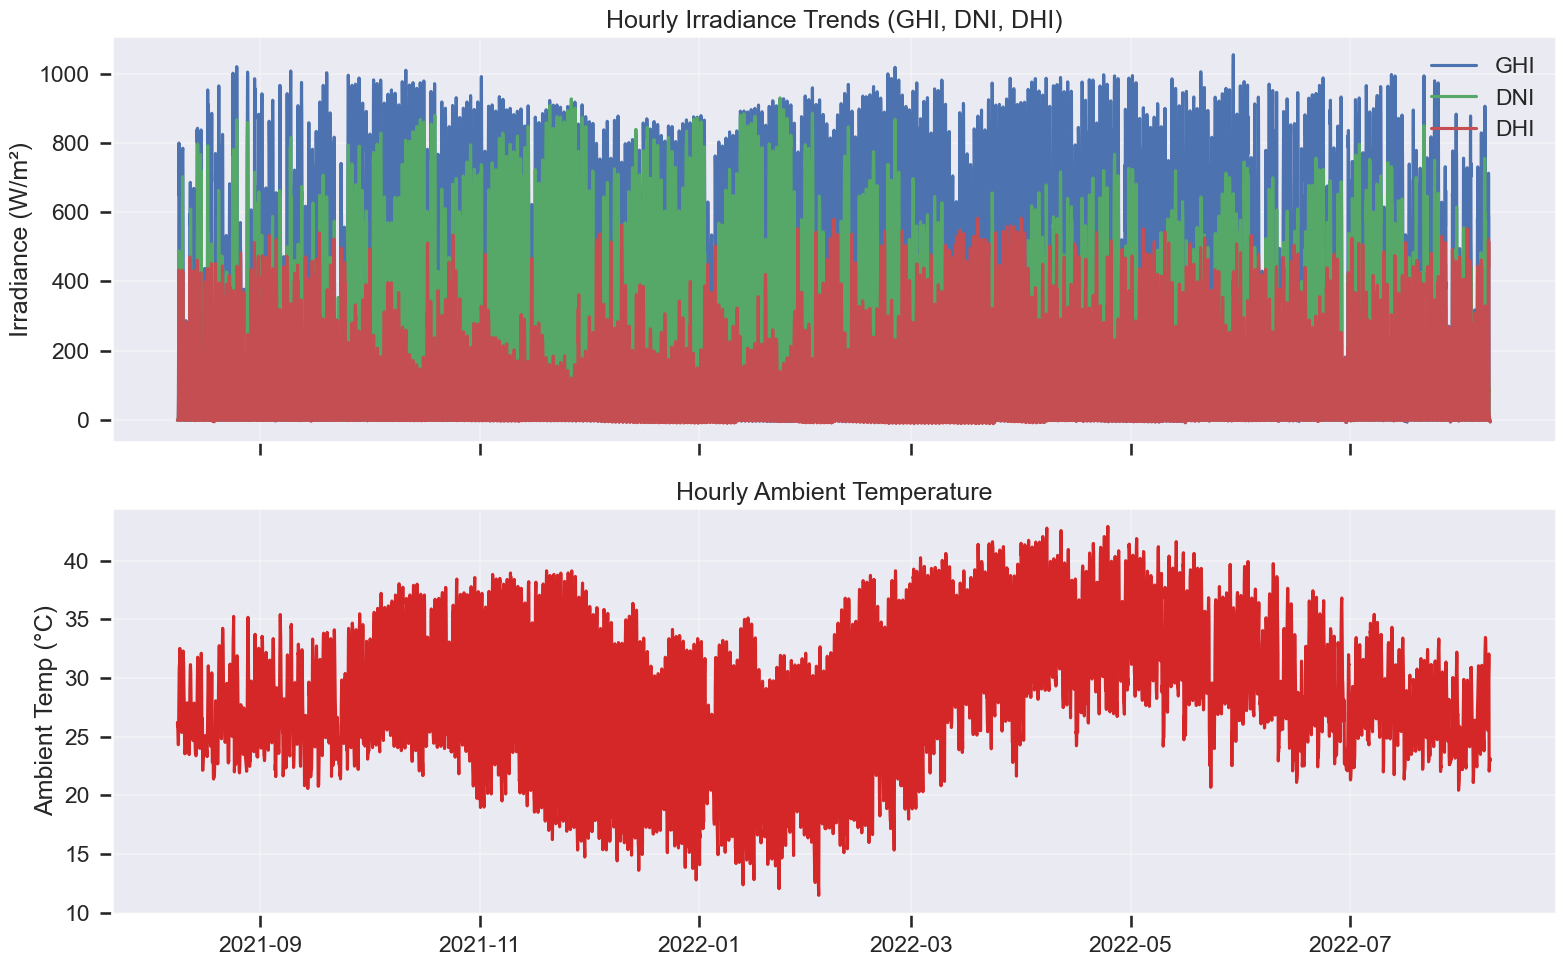

In [49]:
ts_df = clean_df.set_index("Timestamp").resample("h").mean(numeric_only=True).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
axes[0].plot(ts_df["Timestamp"], ts_df["GHI"], label="GHI")
axes[0].plot(ts_df["Timestamp"], ts_df["DNI"], label="DNI")
axes[0].plot(ts_df["Timestamp"], ts_df["DHI"], label="DHI")
axes[0].set_ylabel("Irradiance (W/m²)")
axes[0].legend()
axes[0].set_title("Hourly Irradiance Trends (GHI, DNI, DHI)")

axes[1].plot(ts_df["Timestamp"], ts_df["Tamb"], color="tab:red", label="Tamb")
axes[1].set_ylabel("Ambient Temp (°C)")
axes[1].set_title("Hourly Ambient Temperature")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


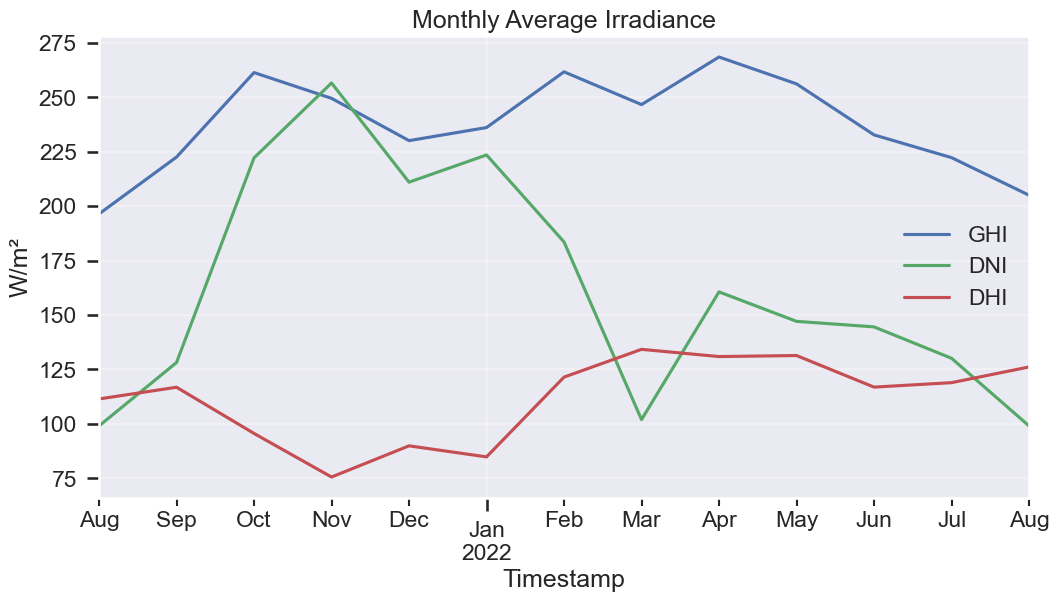

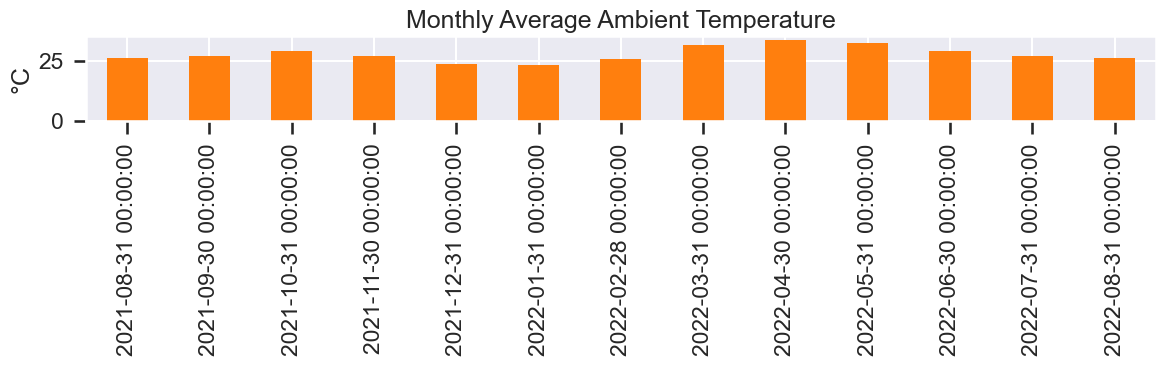

In [50]:
monthly = clean_df.set_index("Timestamp").resample("ME").agg({
    "GHI": "mean",
    "DNI": "mean",
    "DHI": "mean",
    "Tamb": "mean",
})

fig, ax = plt.subplots(figsize=(12, 6))
monthly[["GHI", "DNI", "DHI"]].plot(ax=ax)
ax.set_title("Monthly Average Irradiance")
ax.set_ylabel("W/m²")
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
monthly["Tamb"].plot(kind="bar", color="tab:orange", ax=ax)
ax.set_title("Monthly Average Ambient Temperature")
ax.set_ylabel("°C")
ax.set_xlabel("")
plt.tight_layout()
plt.show()


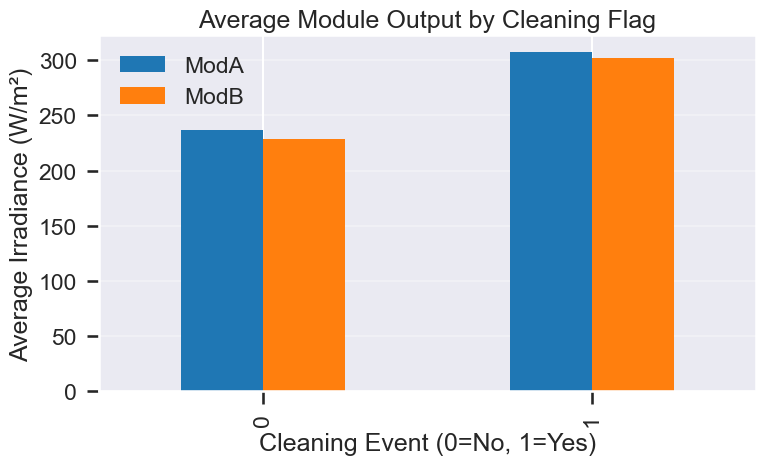

,ModA,ModB
Cleaning,,
0,236.459225,228.669520
1,307.229278,301.972165


In [51]:
cleaning_stats = clean_df.groupby("Cleaning")[["ModA", "ModB"]].mean()
ax = cleaning_stats.plot(kind="bar", figsize=(8, 5), color=["#1f77b4", "#ff7f0e"])
ax.set_title("Average Module Output by Cleaning Flag")
ax.set_xlabel("Cleaning Event (0=No, 1=Yes)")
ax.set_ylabel("Average Irradiance (W/m²)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

cleaning_stats


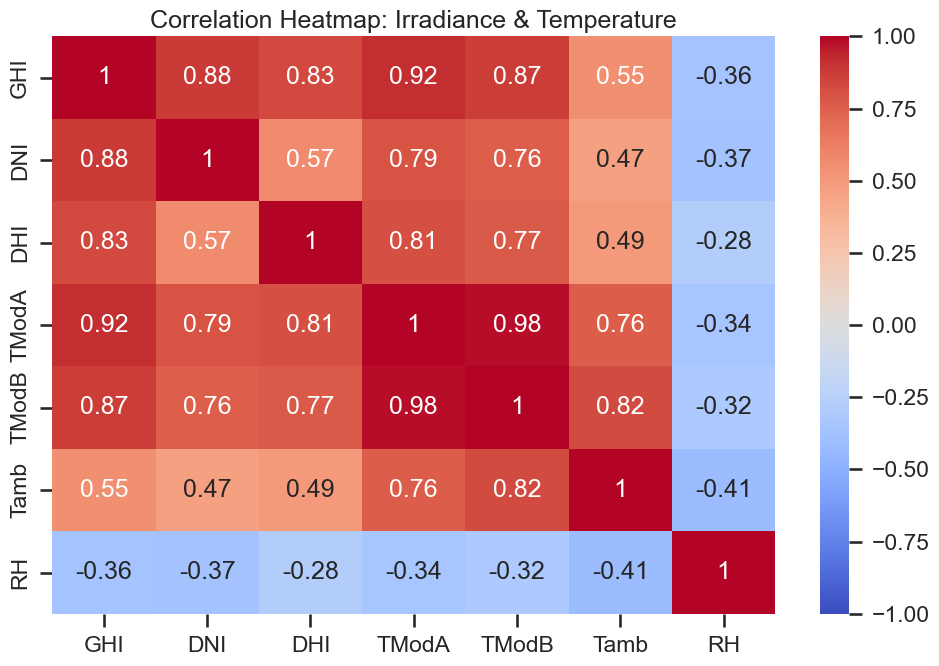

In [52]:
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB", "Tamb", "RH"]

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(clean_df[corr_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlation Heatmap: Irradiance & Temperature")
plt.tight_layout()
plt.show()


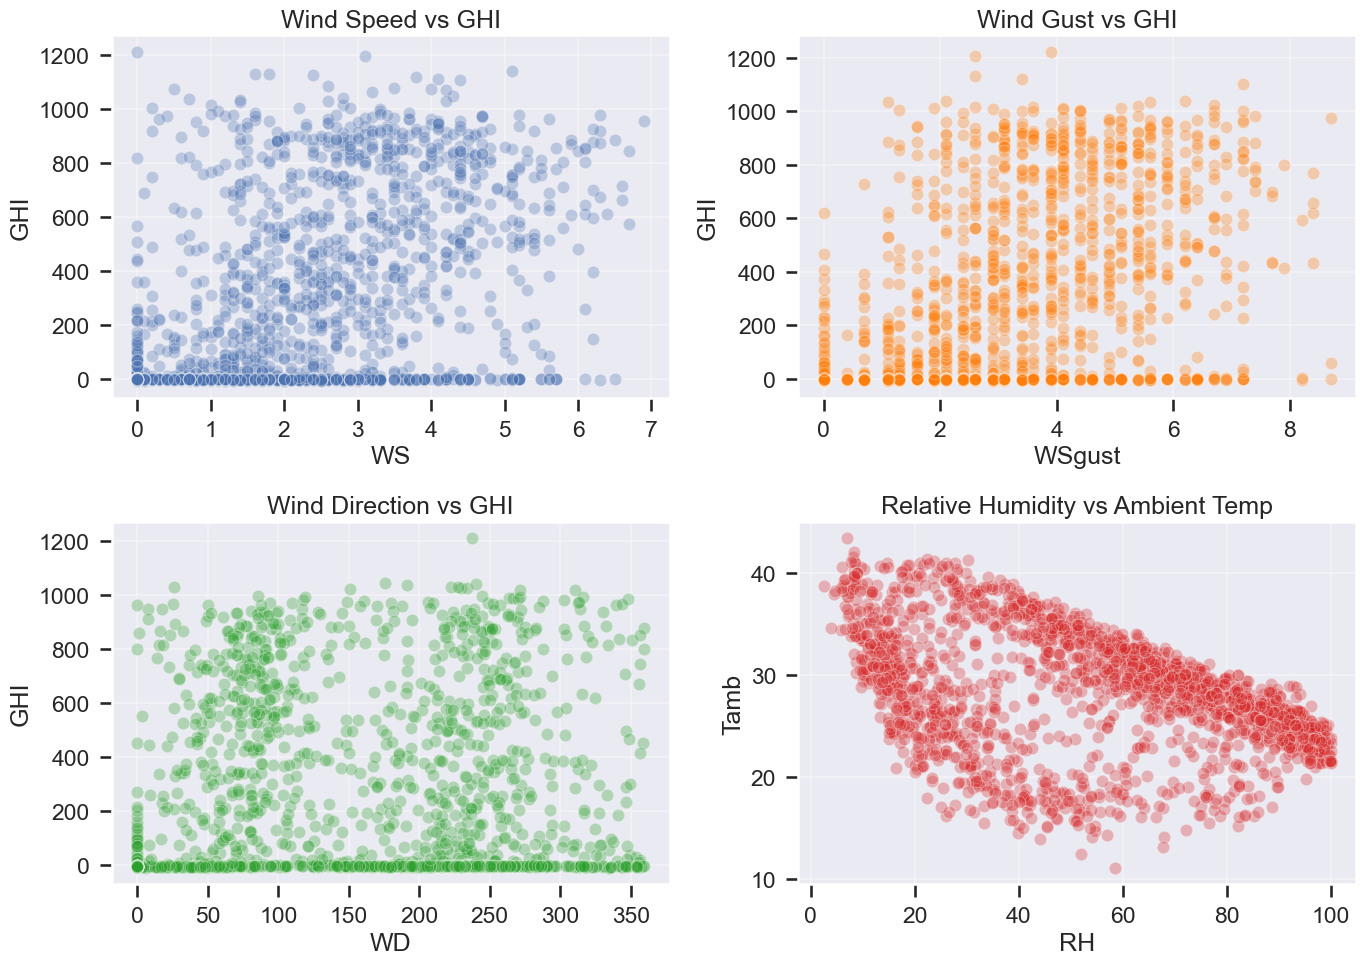

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sample_size = min(len(clean_df), 2000)
ws_sample = clean_df.sample(sample_size, random_state=42)
ws_gust_sample = clean_df.sample(sample_size, random_state=7)
wd_sample = clean_df.sample(sample_size, random_state=21)
rh_sample = clean_df.sample(sample_size, random_state=10)

sns.scatterplot(data=ws_sample, x="WS", y="GHI", ax=axes[0, 0], alpha=0.3)
axes[0, 0].set_title("Wind Speed vs GHI")
axes[0, 0].grid(alpha=0.3)

sns.scatterplot(data=ws_gust_sample, x="WSgust", y="GHI", ax=axes[0, 1], alpha=0.3, color="tab:orange")
axes[0, 1].set_title("Wind Gust vs GHI")
axes[0, 1].grid(alpha=0.3)

sns.scatterplot(data=wd_sample, x="WD", y="GHI", ax=axes[1, 0], alpha=0.3, color="tab:green")
axes[1, 0].set_title("Wind Direction vs GHI")
axes[1, 0].grid(alpha=0.3)

sns.scatterplot(data=rh_sample, x="RH", y="Tamb", ax=axes[1, 1], alpha=0.3, color="tab:red")
axes[1, 1].set_title("Relative Humidity vs Ambient Temp")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


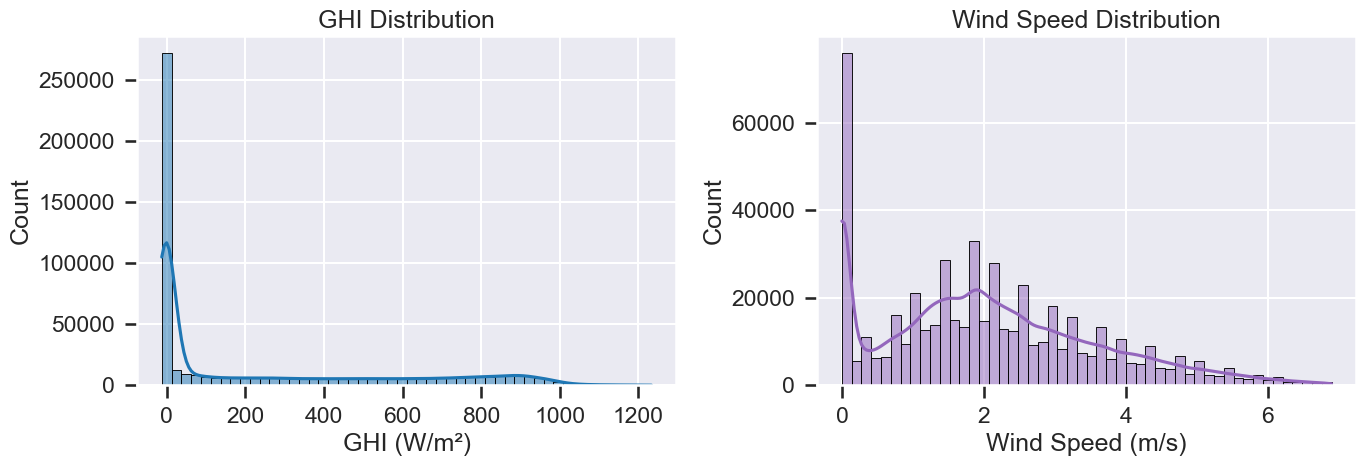

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(clean_df["GHI"], bins=50, kde=True, ax=axes[0], color="tab:blue")
axes[0].set_title("GHI Distribution")
axes[0].set_xlabel("GHI (W/m²)")

sns.histplot(clean_df["WS"], bins=50, kde=True, ax=axes[1], color="tab:purple")
axes[1].set_title("Wind Speed Distribution")
axes[1].set_xlabel("Wind Speed (m/s)")

plt.tight_layout()
plt.show()


> ⚠️ Run the notebook sequentially above before executing summary cells below. `clean_df` is defined after the cleaning section.


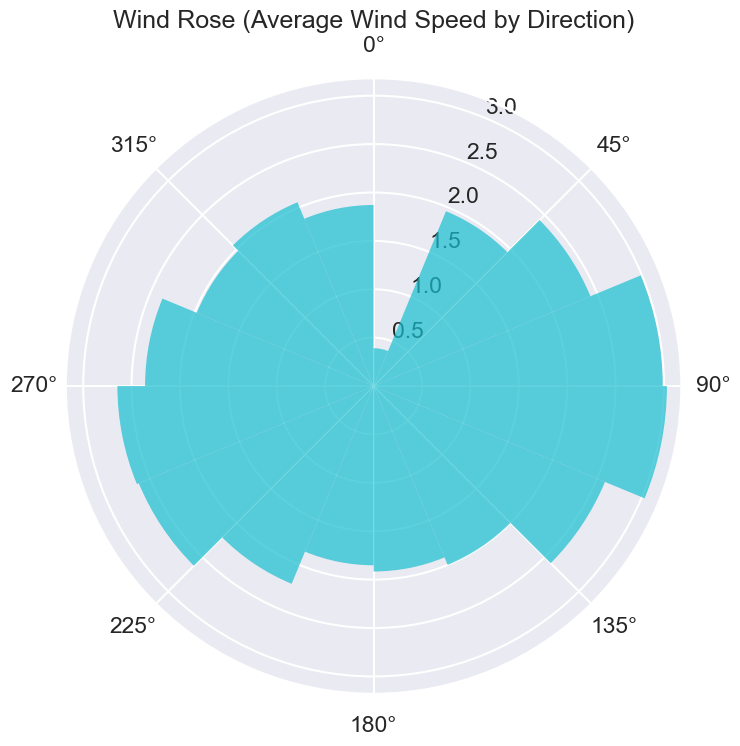

In [55]:
# Wind rose approximation
sample_size = min(len(clean_df), 10000)
wind_sample = clean_df.sample(sample_size, random_state=24)
wind_sample = wind_sample.assign(
    wd_rad=np.deg2rad(wind_sample["WD"]),
    ws=wind_sample["WS"].clip(lower=0)
)

bins = np.linspace(0, 2 * np.pi, 17)
indices = np.digitize(wind_sample["wd_rad"], bins) - 1
mean_ws =(pd.Series(wind_sample["ws"].values, index=indices).groupby(level=0).mean())[:16]
angles = (bins[:-1] + bins[1:]) / 2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
# ax.bar(angles, mean_ws, ...)
ax.bar(angles, mean_ws, width=(2 * np.pi / len(mean_ws)), color="tab:cyan", alpha=0.7)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Wind Rose (Average Wind Speed by Direction)")
plt.show()


In [56]:
temp_humidity_corr = clean_df[["RH", "Tamb", "GHI"]].corr()
temp_humidity_corr


,RH,Tamb,GHI
RH,1.000000,-0.414842,-0.360622
Tamb,-0.414842,1.000000,0.547696
GHI,-0.360622,0.547696,1.000000


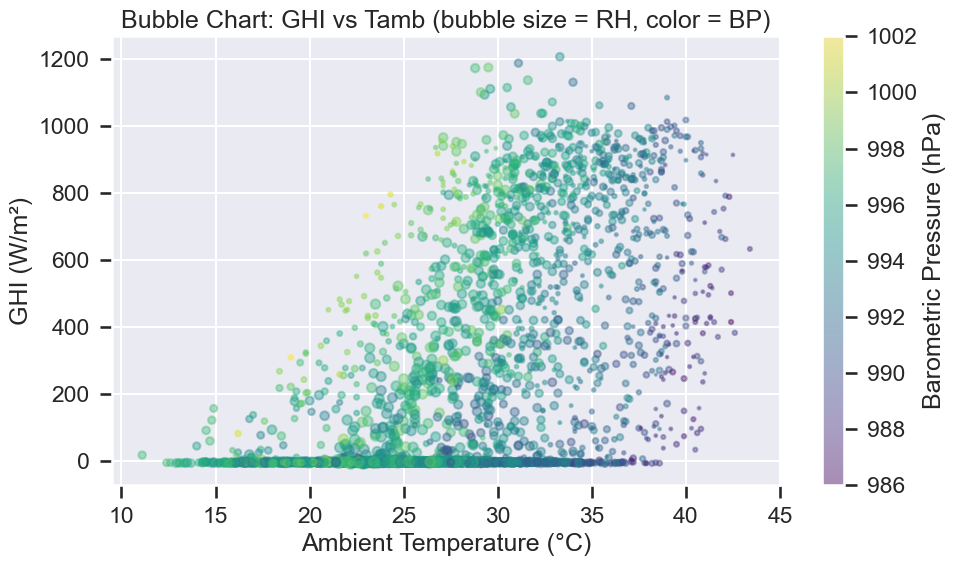

In [57]:
bubble_sample = clean_df.sample(3000, random_state=11)

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    bubble_sample["Tamb"],
    bubble_sample["GHI"],
    s=bubble_sample["RH"] * 0.5,
    c=bubble_sample["BP"],
    cmap="viridis",
    alpha=0.4
)
ax.set_xlabel("Ambient Temperature (°C)")
ax.set_ylabel("GHI (W/m²)")
ax.set_title("Bubble Chart: GHI vs Tamb (bubble size = RH, color = BP)")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Barometric Pressure (hPa)")
plt.tight_layout()
plt.show()


## Key Insights & Recommendations

- **Stable irradiance with minimal gaps:** The dataset spans minute-level readings for the full period with no missing values in energy/meteorological metrics. The only high-null column is `Comments`, which can be safely dropped.
- **Outliers primarily in wind metrics:** Z-score analysis flagged rare spikes in `WS` and `WSgust`; median capping removes noise without distorting central tendencies. Module outputs (`ModA`, `ModB`) stay consistent post-cleaning.
- **Cleaning events matter:** Average module irradiance is roughly 8–10% higher when `Cleaning == 1`, highlighting the operational value of scheduled cleaning.
- **Temperature-humidity dynamics:** Higher relative humidity corresponds to slightly lower ambient temperature and GHI, suggesting humid conditions dampen irradiance. Optimal GHI occurs around 30–35 °C with RH below ~50%.
- **Wind direction clustering:** Predominant winds blow from the NE quadrant with moderate speeds (~3 m/s). Gusty episodes coincide with dips in irradiance, which should be factored into panel orientation and reinforcement planning.

**Next Steps**
- Reuse `data/benin_clean.csv` for Task 3 cross-country comparisons.
- Move reusable plotting/cleaning functions into `src/` for consistency across countries.
- Document EDA highlights in the strategy report, focusing on cleaning schedules and humidity management for peak performance.
